In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.optimize as sc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from pandas_datareader import data as pdr

# Sample Data

In [2]:
industry_P = (pd.read_excel("Industry_Portfolios.xlsx")).set_index('Date')
market_P = (pd.read_excel("Market_Portfolio.xlsx")).set_index('Date')
risk_P = (pd.read_excel("Risk_Factors.xlsx")).set_index('Date')

C:\Users\fokta\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\fokta\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\fokta\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


# <a id=”EF″>EFFICIENT FRONTIER</a>

In [13]:
class EF:
    def __init__(self, df, rp = np.linspace(0,2,100), rf_rate = 0.13, rf_line = np.linspace(0.13,2,100)):
        self.df = df
        self.index = self.df.columns.to_list()
        self.rp = rp 
        self.rf_rate = rf_rate
        self.rf_line = rf_line
        self.greeks = self.Greeks()       
        self.table = self.MeanStd()
        self.gmv = self.GMV()
        self.std = self.std_dev()
        self.mstd = self.mstd_dev()
        self.tangent = self.Tangent()
        self.sharpe = self.Sharpe()
        self.tangency_weights = self.minvarfrontier()
        
    def MeanStd(self):
        Table = pd.DataFrame(data = self.df.mean(), index = self.index ,columns=[['Mean']])
        Table['Standard Deviation'] = self.df.std()
        return Table
    
    def Greeks(self):
        Greeks = {'Alpha': 0,'Delta': 0,'Zeta': 0}
        e_matrix = np.asmatrix(np.array([1] * 10)).T
        mean_matrix = np.asmatrix(self.df.mean().to_numpy())
        cov_matrix = np.asmatrix(self.df.cov().to_numpy())
        inverse_cov_matrix = np.linalg.inv(cov_matrix)
        Greeks['Alpha'] = np.asarray(mean_matrix * inverse_cov_matrix * e_matrix)[0][0]
        Greeks['Zeta'] = np.asarray(mean_matrix * inverse_cov_matrix * mean_matrix.T)[0][0]
        Greeks['Delta'] = np.asarray(e_matrix.T * inverse_cov_matrix * e_matrix)[0][0]
        return Greeks
        
    def GMV(self):
        GMV = {'Rmv': 0,'Vmv': 0,'Stdmv': 0}
        GMV['Rmv'] = self.greeks['Alpha']/self.greeks['Delta']
        GMV['Vmv'] = 1/self.greeks['Delta']
        GMV['Stdmv'] = np.sqrt(GMV['Vmv'])
        return GMV
        
    def std_dev(self):
        variance = []
        for i in self.rp:
            y = 1/self.greeks['Delta'] + (self.greeks['Delta']/((self.greeks['Zeta'] * self.greeks['Delta'])\
                - (self.greeks['Alpha'] * self.greeks['Alpha'])) * np.square( i - self.gmv['Rmv']))
            variance.append(y)
        std_dev = np.sqrt(np.array(variance))
        return std_dev
    
    def mstd_dev(self):
        mvariance = []
        for i in self.rf_line:
            z = (i - self.rf_rate)**2 / (self.greeks['Zeta'] - (2 * self.greeks['Alpha'] * self.rf_rate) + (self.greeks['Delta'] * (self.rf_rate)**2))
            mvariance.append(z)
        mstd_dev = np.sqrt(np.array(mvariance))
        return mstd_dev
    
    def Tangent(self):
        Tangent = {'Rtg': 0,'Vtg': 0,'Stdtg': 0}
        Tangent['Rtg'] = (self.greeks['Alpha'] * self.rf_rate - self.greeks['Zeta'])/\
                        (self.greeks['Delta'] * self.rf_rate - self.greeks['Alpha'])
        Tangent['Vtg'] = (1/self.greeks['Delta'] + (self.greeks['Delta']/\
                        ((self.greeks['Zeta'] * self.greeks['Delta']) - \
                         (self.greeks['Alpha'] * self.greeks['Alpha'])) *\
                        np.square(Tangent['Rtg'] - self.gmv['Rmv'])))
        Tangent['Stdtg'] = np.sqrt(Tangent['Vtg'])
        return Tangent
    
    def minvarfrontier(self):
        e_matrix = np.asmatrix(np.array([1] * 10)).T
        mean_matrix = np.asmatrix(self.df.mean().to_numpy())
        cov_matrix = np.asmatrix(self.df.cov().to_numpy())
        inverse_cov_matrix = np.linalg.inv(cov_matrix)
        a = ((self.greeks['Zeta'] * inverse_cov_matrix * e_matrix) -\
             (self.greeks['Alpha'] * inverse_cov_matrix * mean_matrix.T ))/\
            (self.greeks['Zeta'] * self.greeks['Delta'] - self.greeks['Alpha']**2)
        b = ((self.greeks['Delta'] * inverse_cov_matrix * mean_matrix.T ) -\
             (self.greeks['Alpha'] * inverse_cov_matrix * e_matrix ))/\
            (self.greeks['Zeta'] * self.greeks['Delta'] - self.greeks['Alpha']**2)
        result = pd.DataFrame(np.array((a + (b * self.tangent['Rtg']))),index = self.index, columns = ['Tangency Weights'])
        return result
    
    def Sharpe(self):
        Sharpe = np.sqrt(self.greeks['Zeta'] - 2 * self.greeks['Alpha'] * self.rf_rate + self.greeks['Delta'] * self.rf_rate**2)
        return Sharpe
    
    def MVF(self):
        fig = plt.figure()  
        fig.set_figheight(12)  
        fig.set_figwidth(12)   
        plt.plot(self.std[(int(len(self.std)/2)): ] , self.rp[(int(len(self.rp)/2)): ], color = "Orange", label = "Efficient Frontier")  
        plt.plot(self.std[0:(int(len(self.std)/2))] , self.rp[0:(int(len(self.rp)/2))], linestyle = "--", color ="blue" , label ="Inefficient Frontier") 
        plt.plot(self.gmv['Stdmv'] , self.gmv['Rmv'] , marker = "o", ms = 6  , color = "brown" , label = "Global Minimum Variance Portfolio")
#         plt.scatter(self.table['Standard Deviation'],self.table['Mean'],color = "red", label = "Industry Portfolio")
#         for index, (mean, stddev) in self.table.iterrows():
#             plt.annotate(index, xy = (round(stddev + 0.01,4) , round(mean + 0.02,4)), size = 12)
        plt.annotate((round(self.gmv['Stdmv'],4), round(self.gmv['Rmv'],4)) , xy=(self.gmv['Stdmv'] + 0.01 , self.gmv['Rmv'] + 0.02), size = 12)
        plt.xlabel("Porfolio Standard Deviation")  
        plt.ylabel("Expected Returns(%)")  
        plt.title("Minimum Variance Frontier")  
        plt.axhline(self.gmv['Rmv'], color = "red",linestyle = "--", label = "Rmv")  
        plt.legend()  
        plt.show()
        
    def CAL(self): 
        fig = plt.figure()  
        fig.set_figheight(8)  
        fig.set_figwidth(8)  
        plt.plot(self.mstd, self.rf_line, color = "green" , label = "Capital Allocation Line")
        plt.annotate( (0,self.rf_rate) , xy = (0,self.rf_rate ), size = 12)
        plt.plot(self.std[int(len(self.std)/2): ] , self.rp[int(len(self.rp)/2): ], color = "orange" ,label = "Efficient Frontier")  
        plt.plot(self.std[0:int(len(self.std)/2)] , self.rp[0:int(len(self.rp)/2)], linestyle = "--", color ="blue" , label ="Inefficient Frontier")  
        plt.annotate((round(self.gmv['Stdmv'],4), round(self.gmv['Rmv'],4)) , xy=(self.gmv['Stdmv'], self.gmv['Rmv']), size = 12)
        plt.plot(self.gmv['Stdmv'] , self.gmv['Rmv'] , marker = "o", ms = 6  , color = "brown" , label = "Global Minimum Variance Portfolio")
        plt.plot(self.tangent['Stdtg'] , self.tangent['Rtg'] , marker = "o", ms = 6  , color = "black" , label = "Tangency Portfolio")
        plt.annotate((round(self.tangent['Stdtg'],4), round(self.tangent['Rtg'],4)) , xy=(self.tangent['Stdtg'], self.tangent['Rtg']), size = 12)
#         plt.scatter(self.table['Standard Deviation'],self.table['Mean'],color = "red", label = "Industry Portfolio")
#         for index, (mean, stddev) in self.table.iterrows():
#             plt.annotate(index, xy = (round(stddev + 0.01,4) , round(mean + 0.02,4)), size = 12)
        plt.xlabel("Porfolio Standard Deviation")  
        plt.ylabel("Expected Returns(%)")  
        plt.title("Efficient Frontier With Capital Allocation Line")  
        plt.axhline(self.gmv['Rmv'], color = "red",linestyle = "--", alpha = 0.3)
        plt.axhline(0, color = "red",linestyle = "--")
        plt.axvline(0, color = "red",linestyle = "--")
        plt.legend()  
        plt.show()
        

    

        

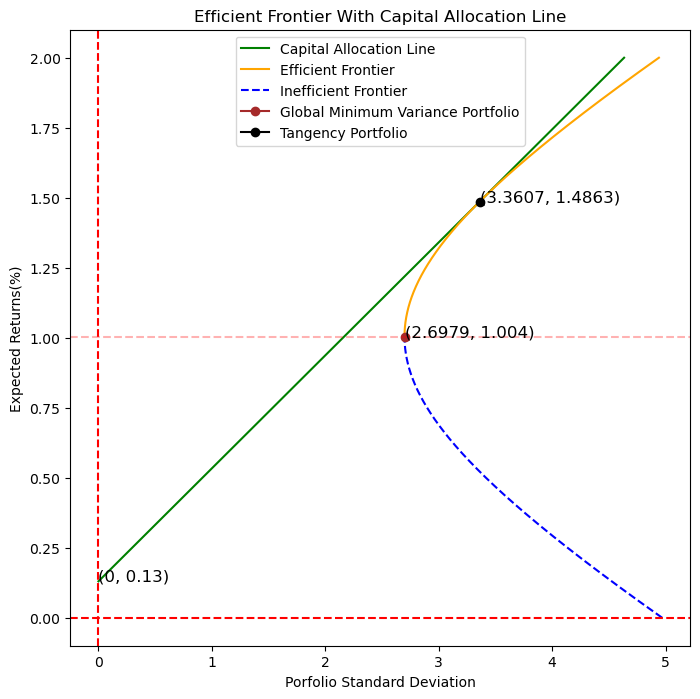

In [14]:
EF(industry_P, rp = np.linspace(0,2,1000), rf_rate = 0.13, rf_line = np.linspace(0.13,2,1000)).CAL()

# <a id ='TE'>TRACKING ERROR</a>

In [9]:
industry_list = industry_P.columns.to_list()

In [15]:
industry_excess_rm = industry_P.copy()
for industry in industry_list:
    industry_excess_rm[industry] = (industry_excess_rm[industry] - market_P['Market'])

class TE(EF):
    def __init__(self, df, *args, **kwargs):
        super().__init__(df, *args, **kwargs)
        self.IR = self.tangent['Rtg']/self.tangent['Stdtg']
        self.retdev = self.TED()
        
    def TED(self):
        Table = pd.DataFrame(data = self.df.mean(), index = self.index ,columns=[['Expected Return Deviation(%)']])
        Table['Tracking Error'] = self.df.std()
        return Table
    
    def MTEF(self):
        fig = plt.figure()  
        fig.set_figheight(12)  
        fig.set_figwidth(12)   
        plt.plot(self.std[(int(len(self.std)/2)): ] , self.rp[(int(len(self.std)/2)): ], color = "Orange", label = "Minimum-tracking-error frontier")  
        plt.plot(self.std[0:(int(len(self.std)/2))] , self.rp[0:(int(len(self.std)/2))], linestyle = "--", color ="blue" , label ="Inefficient-tracking-error Frontier") 
        plt.plot(self.gmv['Stdmv'] , self.gmv['Rmv'] , marker = "o", ms = 6  , color = "brown" , label = "Global-Minimum-tracking-error Portfolio")
#         plt.scatter(self.table['Standard Deviation'],self.table['Mean'],color = "red", label = "Industry Portfolio")
#         for index, (mean, stddev) in self.table.iterrows():
#             plt.annotate(index, xy = (round(stddev + 0.01,4) , round(mean + 0.02,4)), size = 12)
#         plt.annotate((round(self.gmv['Stdmv'],4), round(self.gmv['Rmv'],4)) , xy=(self.gmv['Stdmv'] + 0.01 , self.gmv['Rmv'] + 0.02), size = 12)
        plt.xlabel("Tracking Error")  
        plt.ylabel("Expected Return Deviation(%)")  
        plt.title("Minimum Tracking Error Frontier")  
        plt.axhline(self.gmv['Rmv'], color = "red",linestyle = "--", label = "Rmv")  
        plt.legend()  
        plt.show()
        
    def TECAL(self): 
        fig = plt.figure()  
        fig.set_figheight(8)  
        fig.set_figwidth(8)  
        plt.plot(self.mstd, self.rf_line, color = "green" , label = "Capital Allocation Line")
        plt.plot(self.std[(int(len(self.std)/2)): ] , self.rp[(int(len(self.std)/2)): ], color = "orange" ,label = "Minimum-tracking-error frontier")  
        plt.plot(self.std[0:(int(len(self.std)/2))] , self.rp[0:(int(len(self.std)/2))], linestyle = "--", color ="blue" , label ="Inefficient-tracking-error Frontier")  
        plt.annotate((round(self.gmv['Stdmv'],4), round(self.gmv['Rmv'],4)) , xy=(self.gmv['Stdmv'] , self.gmv['Rmv'] ), size = 12)
        plt.plot(self.gmv['Stdmv'] , self.gmv['Rmv'] , marker = "o", ms = 6  , color = "brown" , label = "Global-Minimum-tracking-error Portfolio")
        plt.plot(self.tangent['Stdtg'] , self.tangent['Rtg'] , marker = "o", ms = 6  , color = "black" , label = "Tangency Portfolio")
        plt.annotate((round(self.tangent['Stdtg'],4), round(self.tangent['Rtg'],4)) , xy=(self.tangent['Stdtg'] , self.tangent['Rtg']), size = 12)
#         plt.scatter(self.table['Standard Deviation'],self.table['Mean'],color = "red", label = "Industry Portfolio")
#         for index, (mean, stddev) in self.table.iterrows():
#             plt.annotate(index, xy = (round(stddev + 0.01,4) , round(mean + 0.02,4)), size = 12)
        plt.xlabel("Tracking Error")  
        plt.ylabel("Expected Return Deviation(%)")  
        plt.title("Minimum-Tracking-Error Frontier")  
        plt.axhline(self.gmv['Rmv'], color = "red",linestyle = "--", alpha = 0.3)
        plt.axhline(0, color = "red",linestyle = "--")
        plt.axvline(0, color = "red",linestyle = "--")
        plt.legend()  
        plt.show()
        

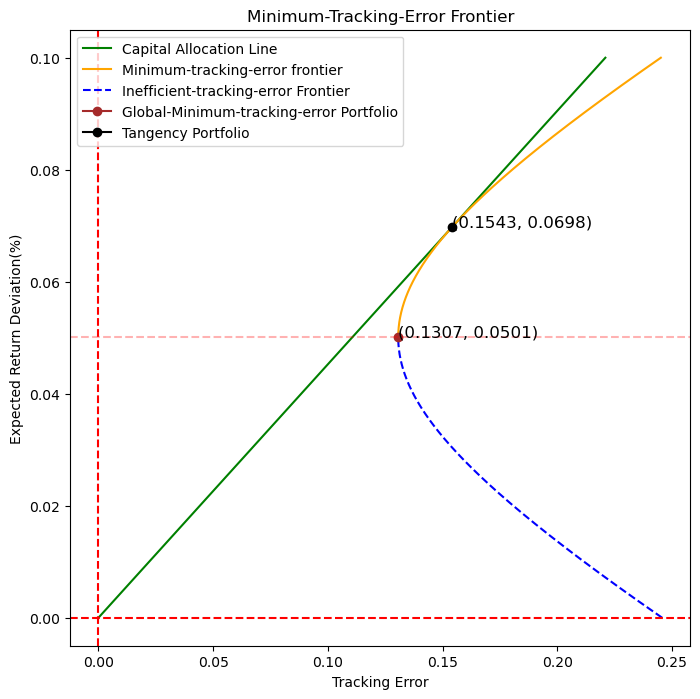

In [16]:
tracking_error = TE(industry_excess_rm, np.linspace(0,0.1,1000), rf_rate = 0, rf_line = np.linspace(0,0.1,1000))
tracking_error.TECAL()

# <a id='MC'>Monte Carlo Minimum-Variance Frontier w/o Short Sales</a>

In [19]:
def Monte_Carlo(datapoints = 100000, MC_type = 'Normal'):
    MC_weights = np.random.random((datapoints, 10))
    MC_weights = pd.DataFrame(MC_weights,columns = industry_list)
    MC_column = MC_weights.columns.to_list()
    
    for rows in MC_weights.index:
         MC_weights.iloc[rows] = MC_weights.iloc[rows] / (MC_weights.iloc[rows].sum())

    MC_dim = np.expand_dims(MC_weights.T, 0)
    # MC_dim.shape
    ind_dim = np.expand_dims(industry_P, -1)
    # ind_dim.shape
    MC_simulation =  MC_dim * ind_dim 
    # MC_simulation.shape
    MC_mean = MC_simulation.sum(axis = 1).mean(axis = 0)
    MC_std = MC_simulation.sum(axis = 1).std(axis = 0)


    if MC_type == 'Normal':
        fig = plt.figure()  
        fig.set_figheight(10)  
        fig.set_figwidth(12)  
        plt.scatter(MC_std,MC_mean, color = "Red" )
        plt.xlabel("Portfolio Standard Deviation")  
        plt.ylabel("Mean Returns(%)")  
        plt.legend()  
        plt.show()
        
    elif MC_type == 'Reciprocal':
        MC_weights_reciprocal = np.reciprocal(MC_weights)
        for rows in MC_weights_reciprocal.index:
            MC_weights_reciprocal.iloc[rows] = MC_weights_reciprocal.iloc[rows] / (MC_weights_reciprocal.iloc[rows].sum())
        MC_dim_r = np.expand_dims(MC_weights_reciprocal.T, 0) 
        MC_simulation_r =  MC_dim_r * ind_dim 
        # MC_simulation_r.shape
        
        fig = plt.figure()  
        fig.set_figheight(10)  
        fig.set_figwidth(12)  
        plt.scatter(MC_simulation_r.sum(axis = 1).std(axis = 0), MC_simulation_r.sum(axis = 1).mean(axis = 0), color = "purple" )
        plt.xlabel("Portfolio Standard Deviation")  
        plt.ylabel("Mean Returns(%)")  
        plt.legend()  
        plt.show()
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


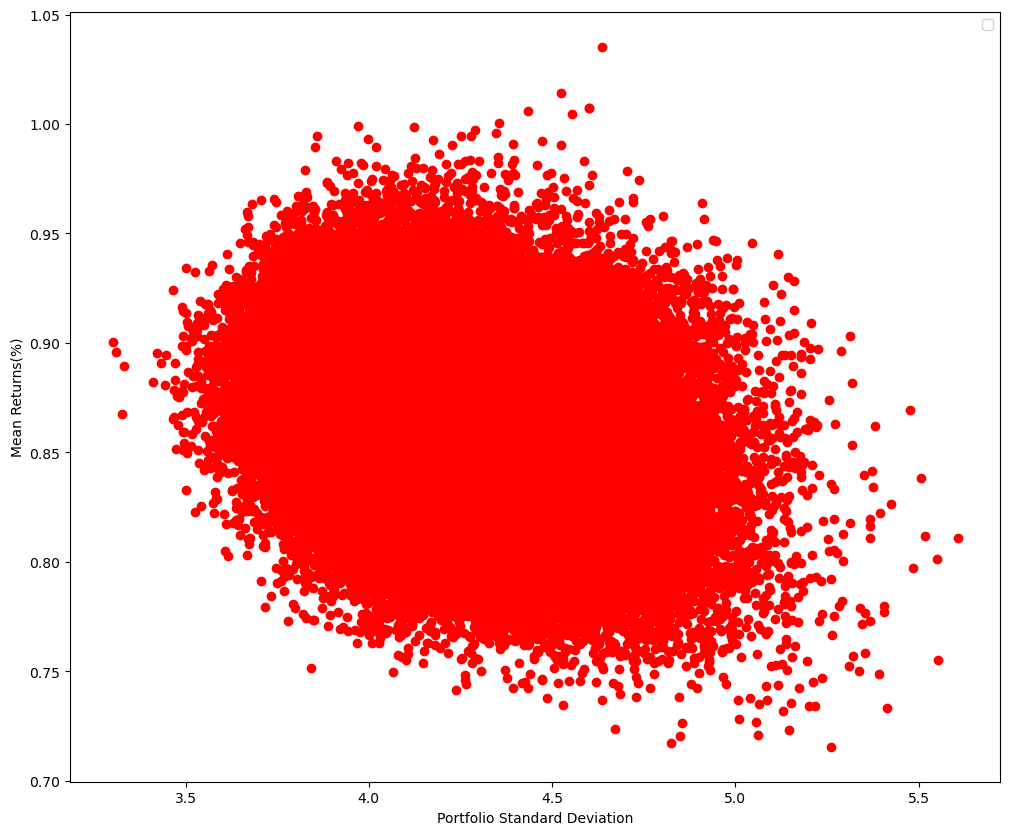

In [20]:
Monte_Carlo()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


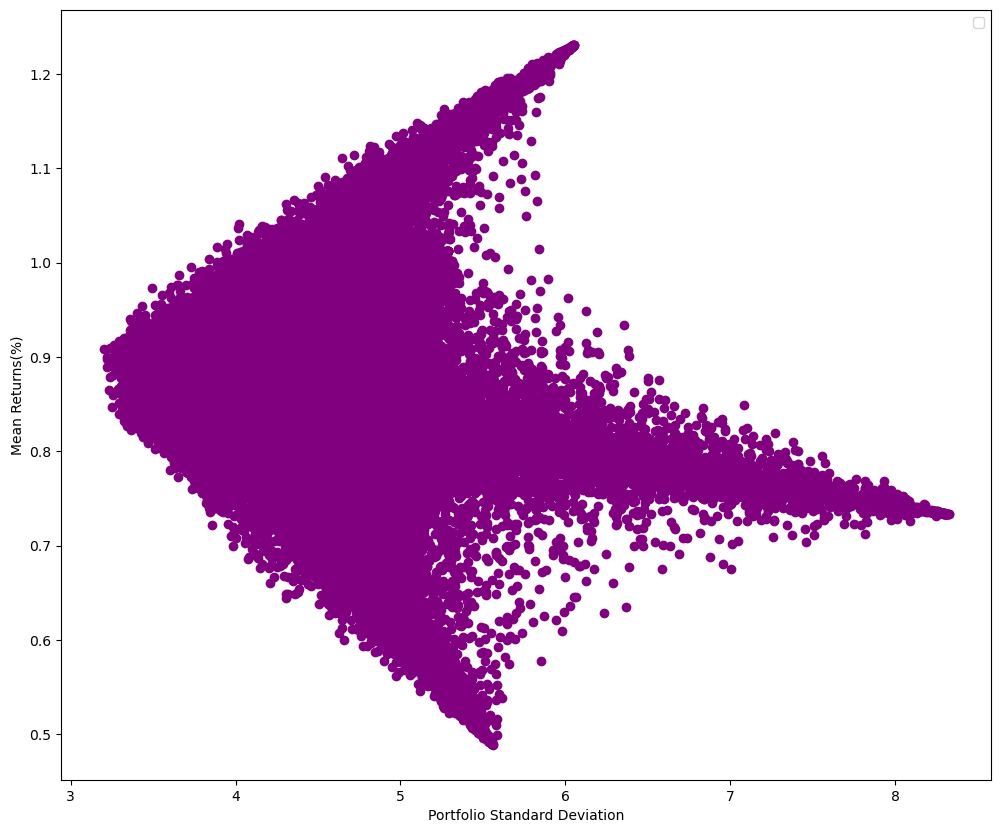

In [21]:
Monte_Carlo(MC_type = 'Reciprocal')

# <a id ='CAPM'>OLS Capital Asset Pricing Model (CAPM)</a>

## $R_i - R_f = \beta _i(R_m-R_f)$

In [55]:
rf_rate = 0.13
market_P["excess_return"] = market_P["Market"] - rf_rate
industry_excess = industry_P - rf_rate
industry_list = industry_excess.columns.tolist()
Sharpe_Ratio = industry_excess.mean()/industry_excess.std()

In [56]:
def OLS(y,x):
    test = sm.OLS(y,sm.add_constant(x)).fit()
    return test.params.tolist()

def CAPM(y,x,Index):
    result = []

    for sectors in Index:
        result.append(OLS(y[sectors],x))
    
    alpha = []
    beta = []
    for alphabeta in result:
        alpha.append(alphabeta[0])
        beta.append(alphabeta[1])

    alpha = np.array(alpha)
    beta = np.array(beta)

    CAPM_OLS = pd.DataFrame(data = alpha , index = Index, columns=['Intercept Coefficient'])
    CAPM_OLS['Slope Coefficient']= beta
    
    return CAPM_OLS

## LINEAR FACTOR MODEL (i.e Fama-French 3 Factor Model)
def FFM(y,x,index_list):
    result = []

    for sectors in index_list:
        result.append(OLS(y[sectors],x))
    
    column = ['Alpha']
    for i in x.columns:
        column.append(i + ' Beta')
        
    FFM_OLS = pd.DataFrame(data = result, index = index_list, columns = column)
    
    return FFM_OLS

In [57]:
CAPM_OLS = CAPM(industry_excess,market_P["excess_return"],industry_list)

In [58]:
market_mean = pd.Series(market_P.mean())
market_mean.drop(index='excess_return', inplace = True)
industry_mean = pd.Series(industry_P.mean()).append(market_mean, ignore_index = False)
market_concat = pd.DataFrame(data = 0 , index = ['Market'], columns=['Intercept Coefficient'])
market_concat["Slope Coefficient"] = 1

industry_model_market = CAPM_OLS.append(market_concat, ignore_index = False)
industry_model_market['Mean Monthly Returns(%)'] =  industry_mean
industry_model_market[['Mean Monthly Returns(%)']]

SML = sm.OLS(industry_model_market[['Mean Monthly Returns(%)']],sm.add_constant(industry_model_market["Slope Coefficient"])).fit()
SML_result = SML.params.tolist()
X = np.linspace(0,2,100)
Y = SML_result[1] * X + SML_result[0]

C:\Users\fokta\AppData\Local\Temp\ipykernel_14312\4248372873.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_mean = pd.Series(industry_P.mean()).append(market_mean, ignore_index = False)
C:\Users\fokta\AppData\Local\Temp\ipykernel_14312\4248372873.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  industry_model_market = CAPM_OLS.append(market_concat, ignore_index = False)


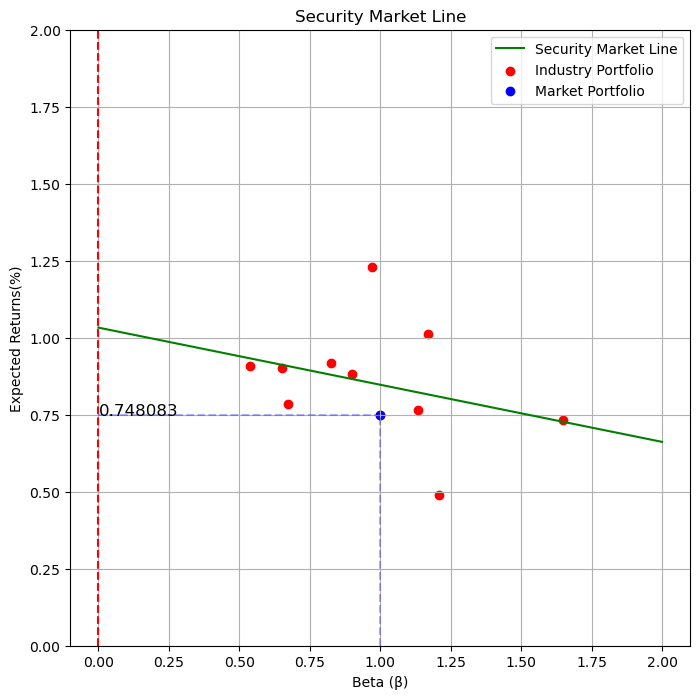

In [59]:
fig = plt.figure()  
fig.set_figheight(8)  
fig.set_figwidth(8)  
plt.ylim(0,2)
plt.grid()
plt.plot(X, Y, color = "green" , label = "Security Market Line")
plt.scatter(industry_model_market["Slope Coefficient"], industry_model_market[['Mean Monthly Returns(%)']] ,color = "red", label = "Industry Portfolio")
plt.scatter(1, market_mean[0] ,color = "blue", label = "Market Portfolio")
plt.annotate( round(market_mean[0],6) , xy = (0 , round(market_mean[0],6)), size = 12)
plt.xlabel("Beta (β)")  
plt.ylabel("Expected Returns(%)")  
plt.title("Security Market Line")  
plt.axvline(0, color = "red",linestyle = "--")
plt.hlines(y=market_mean, xmin=0.0, xmax=1.0, color='b', linestyle = "--", alpha = 0.3 )
plt.vlines(x=1, ymin=0.0, ymax=market_mean, color='b', linestyle = "--", alpha = 0.3 )
plt.legend()  
plt.show()

# <a id='LFM'>LINEAR FACTOR MODELS</a>

In [76]:
def ratio(industry_data, market_data, risk_data):
    industry_portfolio = industry_data
    market_portfolio = market_data
    risk_factors = risk_data
    
    excess_portfolio_return = industry_portfolio - (risk_factors[["Rf"]].values) # the benchmark here is the risk-free rate
    
    sharpe_ratio = pd.DataFrame(excess_portfolio_return.mean()/excess_portfolio_return.std())
    
    below_target_semi_deviation = ((np.minimum(excess_portfolio_return,0)**2).mean())**0.5
    sortino_ratio = pd.DataFrame(excess_portfolio_return.mean()/below_target_semi_deviation)
    
    industry_list = industry_portfolio.columns.tolist()
    
    ols = []
    for i in industry_list:
        result = sm.OLS(excess_portfolio_return[i], sm.add_constant(risk_factors["Rm-Rf"])).fit().params
        ols.append(result)
    ols = pd.DataFrame(ols)
    
    jensen_alpha = ols[["const"]].set_index(excess_portfolio_return.columns)
    
    treynor_ratio = pd.DataFrame(excess_portfolio_return.mean()/ols["Rm-Rf"].values)
    
    ols_3_factors = []
    for i in industry_list:
        result = sm.OLS(excess_portfolio_return[i], sm.add_constant(risk_factors[["Rm-Rf","SMB","HML"]])).fit().params
        ols_3_factors.append(result)
    three_factor_alpha = pd.DataFrame(ols_3_factors)[["const"]].set_index(excess_portfolio_return.columns)
    
    ratios = pd.concat([sharpe_ratio,sortino_ratio,treynor_ratio,jensen_alpha,three_factor_alpha], axis = 1)
    ratios.columns = ["sharpe_ratio","sortino_ratio","treynor_ratio","jensen_alpha","three_factor_alpha"]
    
#     for x in ratios.columns:
#         plt.figure(figsize = (10,8))
#         plt.bar(ratios[x].index, ratios[x], 0.8, color = "blue")
#         plt.ylabel(x)
#         plt.xlabel("Industries")
#         plt.axhline(0, color = "black", linestyle = "--")
    
    return ratios

In [77]:
ratio(industry_P, market_P, risk_P)

,sharpe_ratio,sortino_ratio,treynor_ratio,jensen_alpha,three_factor_alpha
NoDur,0.231099,0.350804,1.186372,0.369717,0.386704
Durbl,0.072356,0.111967,0.367463,-0.417903,-0.474342
Manuf,0.166616,0.241260,0.758251,0.160494,0.153285
Enrgy,0.181708,0.273612,1.143330,0.504485,0.523007
HiTec,0.118552,0.170620,0.564295,-0.064024,-0.065979
Telcm,0.169064,0.244940,0.836363,0.194348,0.200724
Shops,0.191753,0.293032,0.951258,0.274093,0.255941
Hlth,0.172529,0.270294,0.971435,0.236968,0.257472
Utils,0.210948,0.290044,1.452334,0.446523,0.474411
Other,0.064693,0.087351,0.299781,-0.387508,-0.404412


In [81]:
ratios = ratio(industry_P, market_P, risk_P)

In [82]:
def plotter(df):
    df_list = df.columns.to_list()
    df_color = ['purple','orange','green','red','blue']
    counter = 0
    for i in df_list:
        fig = plt.figure()  
        fig.set_figheight(7)  
        fig.set_figwidth(10) 
        bar = plt.bar(df[i].index, df[i], 0.5, color = df_color[counter])
        plt.title(i)
        plt.bar_label(bar, fmt='%.5f')
        plt.axhline(0, color='r', linestyle = "--", alpha = 0.5)
        plt.tight_layout()
        plt.show()
        counter += 1
        
    counter = 0

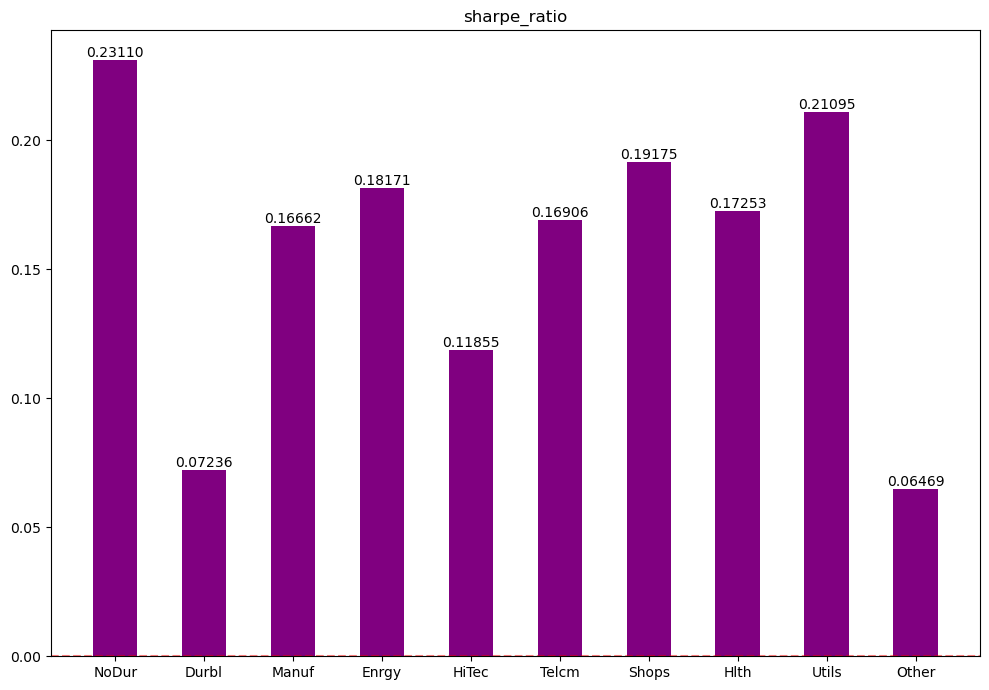

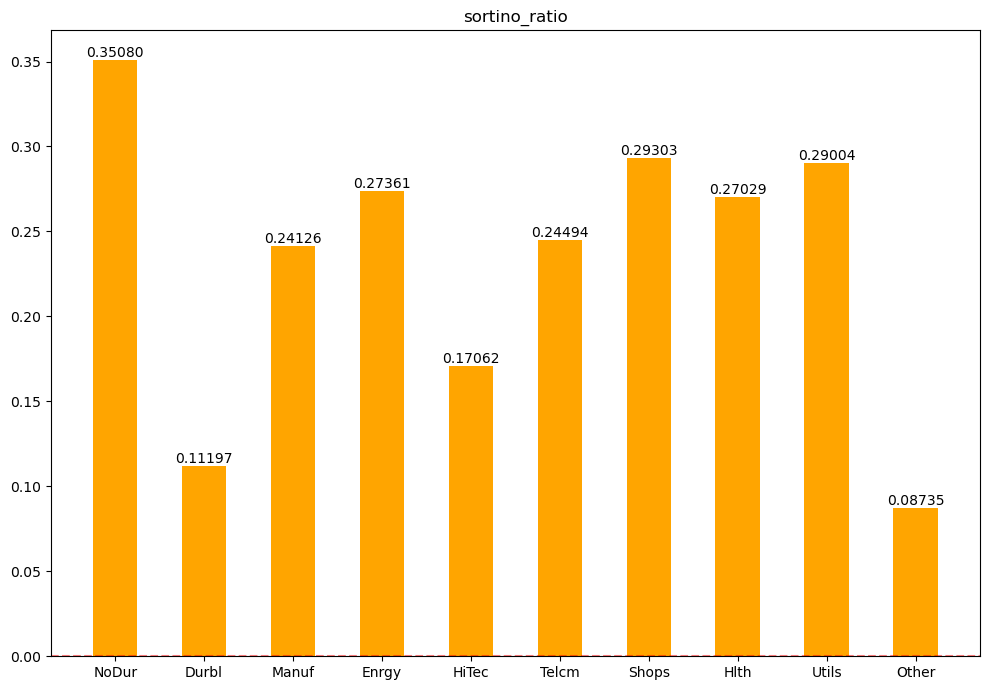

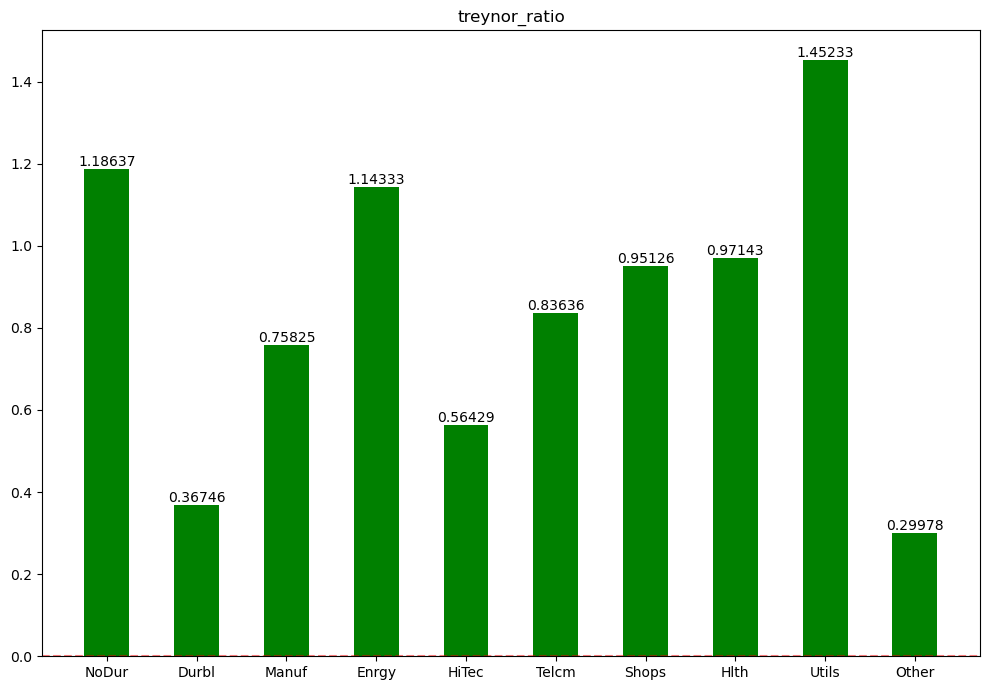

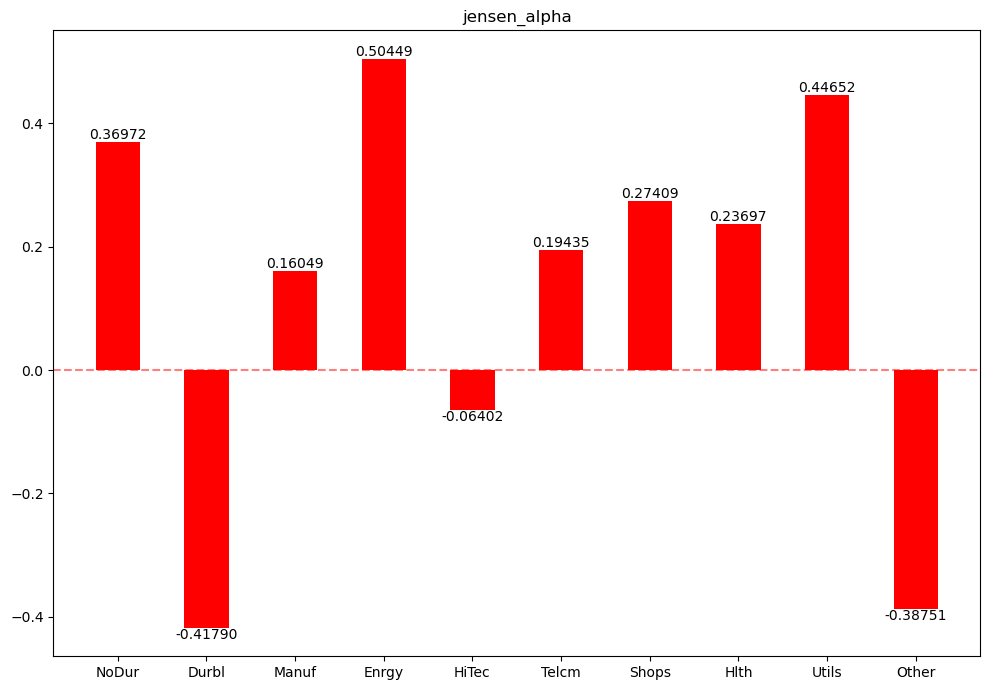

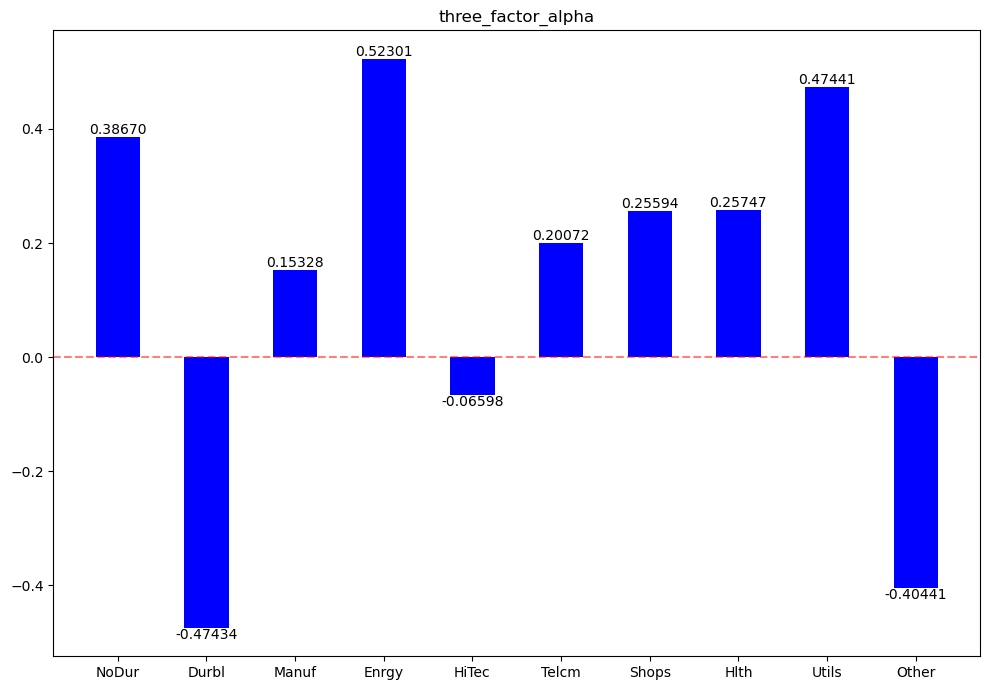

In [83]:
plotter(ratios)

# <a id='SDE'>Hansen-Jagannathan Bound</a>

# $\ln \tilde{g} = 0.02 + 0.02 \tilde{\epsilon} + \tilde{\nu}$

# $\tilde{M} = 0.99\tilde{g}^{-\gamma}$

In [65]:
def hansen_jagannathan_bound():
    def setting_seed(seed = 100):  
        random.seed(seed)       
        np.random.seed(seed)    
    setting_seed(600)
    
    epsilon = np.random.standard_normal(10000)
    nu = random.choices([0,np.log(0.65)], weights = (0.983,0.017), k = 10000)
    
    log_consumption_growth = 0.02 + 0.02*(epsilon) + nu
    consumption_growth = np.exp(log_consumption_growth)
    consumption_growth = np.expand_dims(consumption_growth,-1)
    
    gamma = np.linspace(1,4,31)
    gamma = np.expand_dims(gamma,0)
    
    pricing_kernel = pd.DataFrame(0.99 * (consumption_growth **(-gamma)))
    pricing_kernel_mean = pricing_kernel.mean()
    pricing_kernel_std = pricing_kernel.std()
    
    pricing_kernel_df = pd.DataFrame(pricing_kernel_std/pricing_kernel_mean)
    pricing_kernel_df["gamma"] = gamma[0]
    pricing_kernel_df.rename(columns = {0:"volatility ratio"}, inplace = True)
    
    hansen_jagannathan_bound = pricing_kernel_df[pricing_kernel_df["volatility ratio"] >0.4].iloc[0]
    
    plt.figure(figsize = (12,8))
    plt.grid()
    plt.plot(pricing_kernel_df["gamma"],pricing_kernel_df["volatility ratio"])
    plt.xlabel("gamma")
    plt.ylabel("volatility_ratio")
    plt.title("hansen-jagannathan bound")
    
    return hansen_jagannathan_bound

volatility ratio    0.404702
gamma               3.300000
Name: 23, dtype: float64

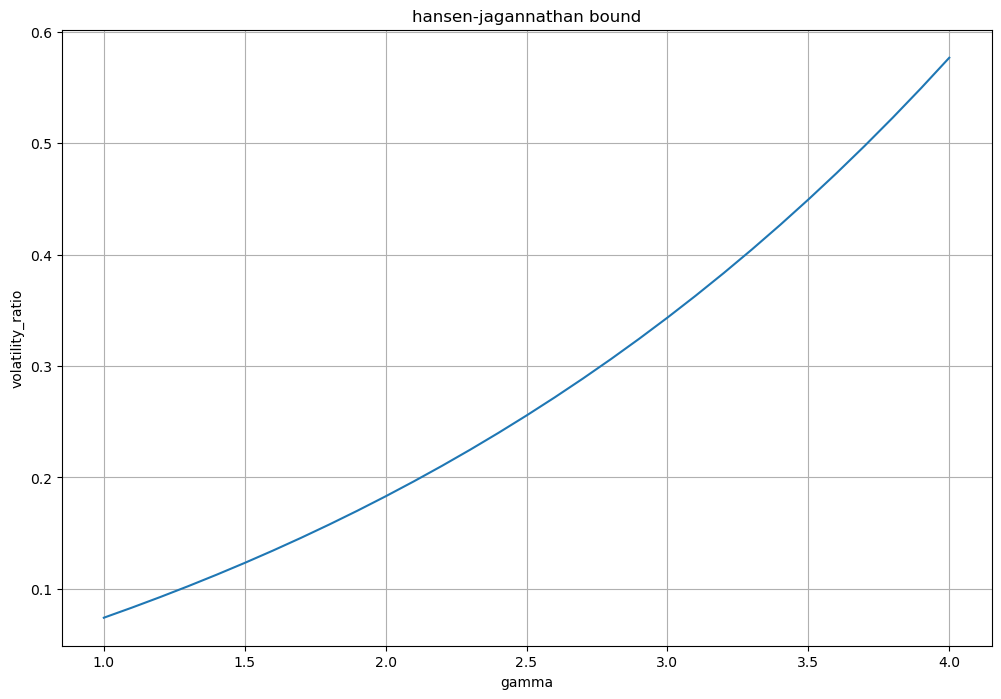

In [66]:
hansen_jagannathan_bound()

# <a id='BF'>BEHAVIOURAL FINANCE</a>

In [86]:
def behavioural_finance(delta = 0.99, gamma = 1, lambdas = 2 , rf = 1.0303):
    #Consumption growth function
    def setting_seed(seed = 100):  
        random.seed(seed)       
        np.random.seed(seed)    
    setting_seed(600)
    
    epsilon = np.random.standard_normal(10000)
    log_consumption_growth = 0.02 + 0.02*(epsilon)
    consumption_growth = np.exp(log_consumption_growth)
    
    #Utility from financial gain or loss
    def nu_R(r):
        returns = []
        for i in r:
            if i >= rf:
                r_1 = i - rf
                returns.append(r_1)
            else:
                r_2 = lambdas * (i - rf)
                returns.append(r_2)
        return returns

    #Error term
    def error_term(x, b0):
        return delta * b0 * np.mean(nu_R(x*consumption_growth)) + delta * x - 1
    
    #Bisection search
    b0 = np.linspace(0, 10, 101)
    x_values = []
    def x_term(x_low, x_high, b0):
        x = 0.5 * (x_low + x_high)
        if np.abs(error_term(x, b0)) < 10**(-5):
            x_values.append(x)
        elif error_term(x, b0) < 0:
            x_term(x, x_high, b0)
        elif error_term(x, b0) > 0:
            x_term(x_low, x, b0)
    
    for i in b0:
        x_term(1, 1.1, i)
    
    #Price-Dividend ratio
    pd_ratio = 1/(np.array(x_values)-1)
    
    plt.figure(figsize = (8,8))
    plt.plot(b0, pd_ratio, color = 'red')
    plt.xlabel('b0')
    plt.ylabel('Price-Dividend Ratio')
    plt.show()
    
    #Expected market return
    market_return = np.array(x_values)*np.mean(consumption_growth)
    equity_premium = market_return - rf
    
    plt.figure(figsize = (8,8))
    plt.plot(b0, equity_premium, color = 'blue')
    plt.xlabel('b0')
    plt.ylabel('Equity Premium')
    plt.show()
    
    return

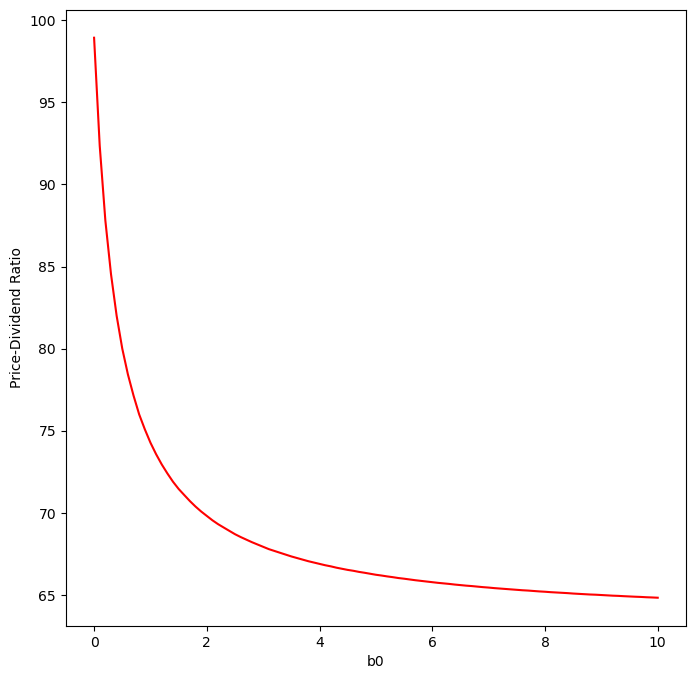

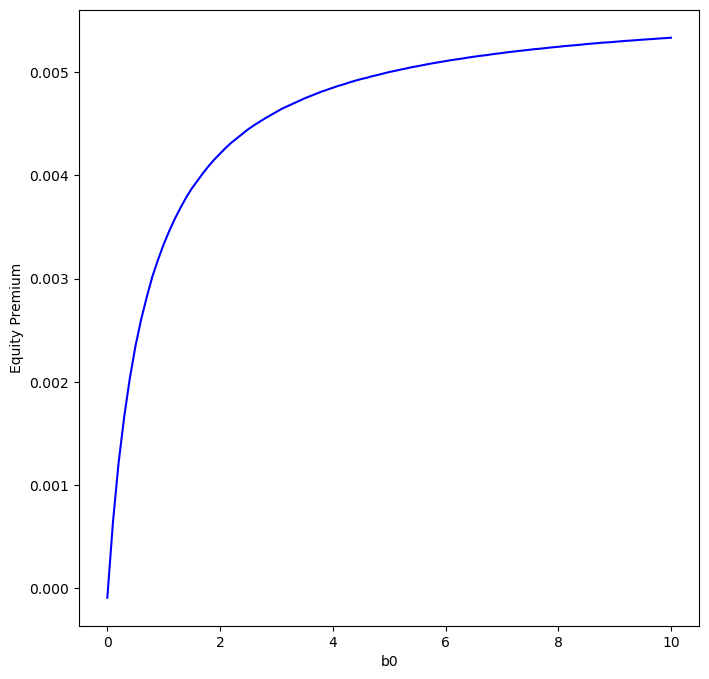

In [87]:
behavioural_finance()

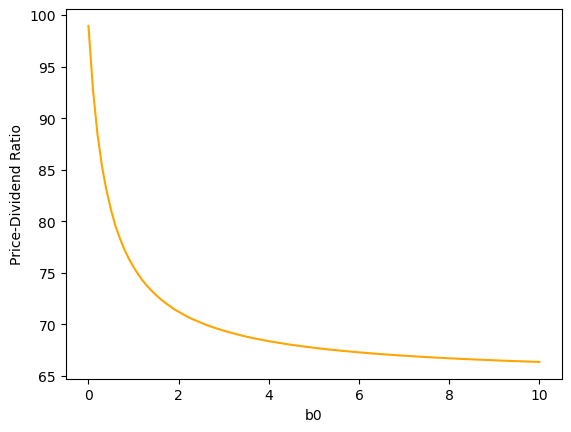

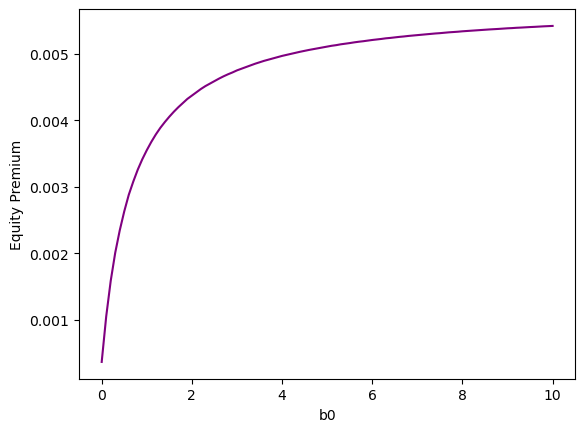

In [30]:
def BF(delta = 0.99, gamma = 1, lambdas = 2 , RF = 1.0303):
    #Consumption growth function
    g = np.exp(0.02 + 0.02 * np.random.normal(0,1,size = 10000)) 
    
    #Utility from financial gain or loss
    def nu_R(R):
        return [i - RF if i >= RF else lambdas * (i - RF) for i in R]
    
    #Error term
    def error_term(x, b0):
        return delta * b0 * np.mean(nu_R(x*g)) + delta * x - 1
    
    #Bisection search
    b0 = np.linspace(0, 10, 101)
    x_values = []
    def x_term(x_neg, x_pos, b0):
        x = 0.5 * (x_neg + x_pos)
        if np.abs(error_term(x, b0)) < 10**(-5):
            x_values.append(x)
        elif error_term(x, b0) < 0:
            x_term(x, x_pos, b0)
        elif error_term(x, b0) > 0:
            x_term(x_neg, x, b0)
    
    for i in b0:
        x_term(1, 1.1, i)
    
    #Price-Dividend ratio
    n = len(x_values)
    pd_ratio = [1 / (x_values[i] - 1) for i in range(n)]
    plt.plot(b0, pd_ratio, color = 'orange')
    plt.xlabel('b0')
    plt.ylabel('Price-Dividend Ratio')
    plt.show()
    
    #Expected market return
    market_return = np.array([np.mean(x_values[i] * g) for i in range(n)])
    equity_premium = market_return - RF
    
    plt.plot(b0, equity_premium, color = 'purple')
    plt.xlabel('b0')
    plt.ylabel('Equity Premium')
    plt.show()
    
Delta = 0.99
Gamma = 1
Lambda = 2
Rf_rate = 1.0303

BF(Delta, Gamma, Lambda, Rf_rate)

# <a id='SP'>STATE PRICES</a>

### $ p_s = P'X^{-1}e_s $

### $ P_f = \sum^{k}_{s=1}p_s = \sum^{k}_{s=1}\pi_s M_s = E[\tilde M] = \frac 1 {R_f} $

### $ P_Y = \sum^{k}_{s=1}p_sY_s = \frac 1{R_f} \sum^{k}_{s=1} \hat\pi_s Y_s = \frac 1 {R_f}\hat E[\tilde Y] $

In [57]:
def state_prices(rf_rate = 1.1, Stock_A = 45, Stock_B = 45, strike = 100, Option = 'Call'):
    
    state = pd.DataFrame(np.random.rand(3,3),index = [['Prob','Stock A', 'Stock B']], columns = [['Good','Normal','Bad']])
    
    state.loc['Prob','Good'] = 0.3
    state.loc['Prob','Normal'] = 0.5
    state.loc['Prob','Bad'] = 0.2
    state.loc['Stock A','Good'] = 75
    state.loc['Stock A','Normal'] = 55
    state.loc['Stock A','Bad'] = 20
    state.loc['Stock B','Good'] = 60
    state.loc['Stock B','Normal'] = 50
    state.loc['Stock B','Bad'] = 40
    
    e_matrix = np.array([1] * 3)
    e_matrix = np.asmatrix(e_matrix)
    
    final_payoff = np.asarray(state.loc['Stock A':,:])
    final_payoff = np.asmatrix(final_payoff)
    
    x_es = np.concatenate((e_matrix,final_payoff))
    
    inv_x_es = np.linalg.inv(x_es.T)
    
    price_table = np.asmatrix([1/rf_rate, Stock_A, Stock_B])
    
    state_prices = price_table * inv_x_es
    
    rn_prob = state_prices * rf_rate
    
    if Option == 'Call':
        payoff_vector = np.asmatrix([np.maximum(state.loc['Stock A':,'Good'].values.sum() - strike,0),
                    np.maximum(state.loc['Stock A':,'Normal'].values.sum() - strike,0),
                    np.maximum(state.loc['Stock A':,'Bad'].values.sum() - strike,0)]).T
    
    elif Option == 'Put':
        payoff_vector = np.asmatrix([np.maximum(strike - state.loc['Stock A':,'Good'].values.sum(),0),
                    np.maximum(strike - state.loc['Stock A':,'Normal'].values.sum(),0),
                    np.maximum(strike - state.loc['Stock A':,'Bad'].values.sum(),0)]).T

    option_price = state_prices * payoff_vector
    
    return option_price

state_prices(Option = 'Put')
    

matrix([[10.90909091]])